# Agent s  Q-učením

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show_animation(agent, env, steps=200, episodes=1):
    for i in range(episodes):
        observation = env.reset()[0]
        done = False
        terminated = False
        total_reward = 0
        time = 0
        reward = 0
        while not (done or terminated) and time < steps:
            env.render()
            action = agent.act(observation, reward, done)
            observation, reward, done, terminated, _  = env.step(action)
            total_reward += reward
            time += 1
        agent.reset()

def moving_average(x, n):
    weights = np.ones(n)/n
    return np.convolve(np.asarray(x), weights, mode='valid')

In [3]:
class StateDiscretizer:
  # dostane stavy a rozmery prostredi
    def __init__(self, ranges, states):
        self.ranges = ranges
        self.states = states
        self.bins = []

        ranges_positions = ranges[0]
        ranges_speed = ranges[1]

        # rozdeli mnozinu od param1 do param2 na param3 podoblasti
        bins_position = np.linspace(ranges_positions[0], ranges_positions[1], states[0])
        bins_speed = np.linspace(ranges_speed[0], ranges_speed[1], states[1])

        # prida si nove stavy do binu
        self.bins.append(bins_position)
        self.bins.append(bins_speed)

        # celkovy pocet stavu
        self.num_states = np.prod(self.states)

    # priradit stav do spravnyho intervalu
    def transform(self, obs):

        # vraci indexy binu pro kazdou hodnotu
        position = np.digitize(obs[0], self.bins[0])
        speed = np.digitize(obs[1], self.bins[1])

        # vypocita cislo stavu podle pozice a rychlosti
        state_num = (position - 1)*self.states[0] + speed - 1

        if state_num < 0 or state_num >= self.num_states:
            raise UserWarning('the observation was outside the specified range')

        if 0 <= state_num < self.num_states:
            return state_num  
        return 0 # observation outside specified ranges

class QLearningAgent:  
    def __init__(self, actions, state_transformer, train=False):
        # nastaveni moznych akci - L, N, R   
        self.actions = actions

        # diskretizace stavu prostredi
        self.state_transformer = state_transformer

        # definice matice uzitku Q[stavy, akce]
        self.Q = np.zeros((state_transformer.num_states, self.actions.n))
        self.train = train

        # promenna na zapamatovani si minuleho stavu a minule akce
        self.last_state = None
        self.last_action = None

        # donastaveni dalsich parametru trenovani
        self.alpha = 0.1
        self.gamma = 0.9
        self.eps = 0.1

    # na zaklade stavu a akce se vybira nova akce
    def act(self, observe, reward, done):
    
        # 1. najde se nejlepsi akce pro dany stav
        current_state = self.state_transformer.transform(observe)
        current_action = np.argmax(self.Q[current_state, :])

        # 2. s malou pravd. vezme nahodnou
        if self.train and self.last_state:
            if np.random.random() < self.eps:
                current_action = self.actions.sample()
            # 3. updatuje se Q matice 
            self.Q[self.last_state, self.last_action] = (1-self.alpha)*self.Q[self.last_state, self.last_action] + \
            self.alpha*(reward + self.gamma*self.Q[current_state, current_action])

        self.last_state = current_state
        self.last_action = current_action

        return current_action

    # reset minuleho stavu a akce na konci epizody
    def reset(self):
        self.last_state = None
        self.last_action = None

C:\Users\katie\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\envs\classic_control\mountain_car.py:173: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCar-v0", render_mode="rgb_array")
  gym.logger.warn(


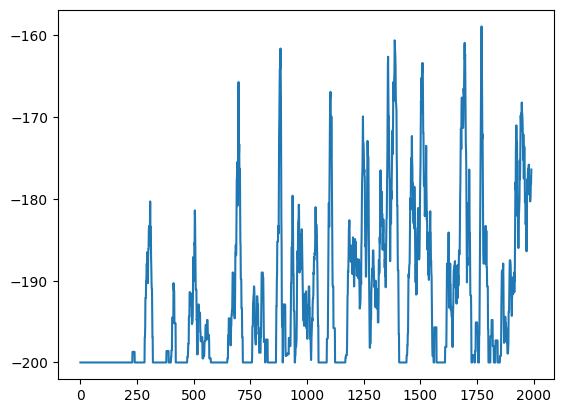

In [4]:
env = gym.make('MountainCar-v0')
obs = env.reset()

states = [15,15]
states_range = [env.observation_space.low[0],env.observation_space.high[0]]
speed_range = [env.observation_space.low[1],env.observation_space.high[1]]
ranges =  [states_range, speed_range]
discretizer = StateDiscretizer(ranges,states)
agent = QLearningAgent(env.action_space,discretizer, True)

total_rewards = []
for i in range(2000):
    obs = env.reset()[0]
    agent.reset()
    
    terminated = False
    done = False
    r = 0
    R = 0
    t = 0 
    
    while not (done or terminated):
        action = agent.act(obs, r, done) 
        obs, r, done, terminated, _ = env.step(action)
        R += r
        t += 1

    total_rewards.append(R)
agent.train = False

show_animation(agent, env, steps=1000, episodes=10)
plt.plot(moving_average(total_rewards, 10))
plt.show() 
env.close()

In [5]:
show_animation(agent, env, steps=1000, episodes=100)